In [4]:
import numpy as np 
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
import tifffile

2024-05-22 09:59:22.638429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 09:59:22.638563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 09:59:22.787762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import h5py
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import os
# np.set_printoptions(threshold=1000000)
import math

from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Dropout, UpSampling2D, ZeroPadding2D, AveragePooling2D, Conv2DTranspose
from keras.layers import Flatten, Cropping1D, Reshape
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
# from keras.engine.topology import Layer
from keras.layers import Lambda, Input
import tensorflow as tf
from itertools import product

from keras.layers import Input, Dense, Add
from keras.models import Model
from itertools import chain


import random
from datetime import datetime

from skimage.filters import gaussian
from skimage.morphology import dilation, disk


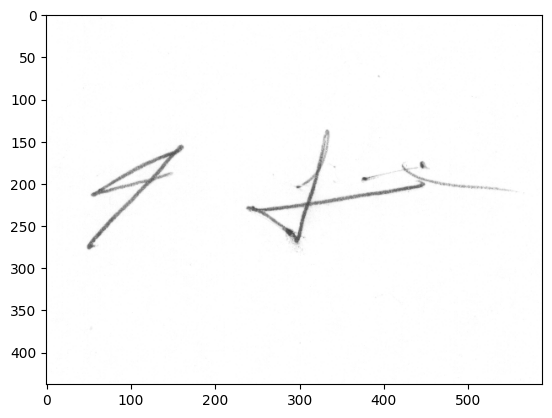

In [6]:
img = plt.imread('../input/handwritten-signature-datasets/CEDAR/CEDAR/1/forgeries_1_1.png')
plt.imshow(img)

# To show the bengali and hindi tif images
# img_path = '../input/handwritten-signature-datasets/BHSig260-Bengali/BHSig260-Bengali/80/B-S-80-F-20.tif'
# img = tifffile.imread(img_path)
# plt.imshow(hindi_images[0])

In [7]:
# To load all the images and labeling them. (Forgery/Genuine)

def load_images_from_folder(folder, dataset_type):
    
    images = []
    labels = []
    
    for root, dirs, files in os.walk(folder):
        for file in files:
            
            if file.endswith(".png") or file.endswith(".tif"):
                
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)#, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    
                    images.append(img)
                    if dataset_type == 'cedar':
                        label = 'forgery' if 'forgeries' in file else 'genuine'
                    elif dataset_type == 'bengali':
                        label = 'forgery' if 'F' in file else 'genuine'
                    elif dataset_type == 'hindi':
                        label = 'forgery' if 'F' in file else 'genuine'
                    else:
                        raise ValueError(f"Invalid dataset_type: {dataset_type}")
                    
                    labels.append(label)
                else:
                    print(f"Failed to load image: {img_path}")
    
    print(f"Loaded {len(images)} images from {folder}")
    return images, labels

In [9]:
def preprocess_images(images):
    processed_images = []
    filtered_images = []
    grayscaled_images = []
    for img in images:
        
        # Converting to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # For Filtered image
        filtered_img = cv2.GaussianBlur(cv2.dilate(gray, (3, 3), iterations=1), (5, 5), 0)
        
        # Applying Otsu thresholding for binarization
        _, thresh = cv2.threshold(filtered_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # To Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # for the extraction of bounding rectangle
        x, y, w, h = cv2.boundingRect(contours[0])

        # Extract signature area
        signature_area = thresh[y:y+h, x:x+w]

        # Resizing both images to a fixed size for training
        filtered_img = cv2.resize(filtered_img, (256, 128))
        grayscale_img = cv2.resize(signature_area, (256, 128))
        
        grayscaled_images.append(grayscale_img)
        
        processed_images.append([filtered_img, grayscale_img])
        filtered_images.append(filtered_img)

    processed_images = np.array(processed_images, dtype='float32') / 255.0  # Normalize pixel values
    filtered_images = np.array(filtered_images, dtype='float32') / 255.0  # Normalize pixel values
    grayscaled_images = np.array(grayscaled_images, dtype='float32') / 255.0
#     return processed_images
    return grayscaled_images
#     return filtered_images

In [10]:
cedar_images, cedar_labels = load_images_from_folder('../input/handwritten-signature-datasets/CEDAR/CEDAR/', 'cedar')
# bengali_images, bengali_labels = load_images_from_folder('../input/handwritten-signature-datasets/BHSig260-Bengali/BHSig260-Bengali/', 'bengali')
hindi_images, hindi_labels = load_images_from_folder('../input/handwritten-signature-datasets/BHSig260-Hindi/BHSig260-Hindi/', 'hindi')

# Here, we can use the bengali images and labels too, but due to computational and time limitations, I have only used the CEDAR and Hindi signature datasets.
# With more data, the training would possibly be better

Loaded 2640 images from ../input/handwritten-signature-datasets/CEDAR/CEDAR/
Loaded 8640 images from ../input/handwritten-signature-datasets/BHSig260-Hindi/BHSig260-Hindi/


In [39]:
print(np.shape(images[3339]))
# print(np.shape(hindi_images[0]))
# print(np.shape(hindi_images[6]))
# print(np.shape(bengali_images[24]))

(285, 1031, 3)


In [13]:
# del(labels)
# del(hindi_labels)
# del(bengali_labels)
# del(cedar_labels)
import gc
gc.collect()

579

In [14]:
# Preprocess images
processed_images = preprocess_images(images)

1035
forgery


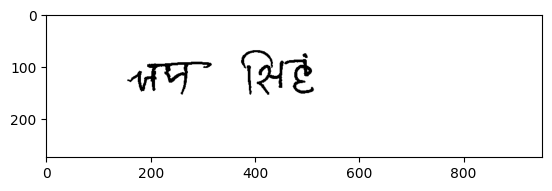

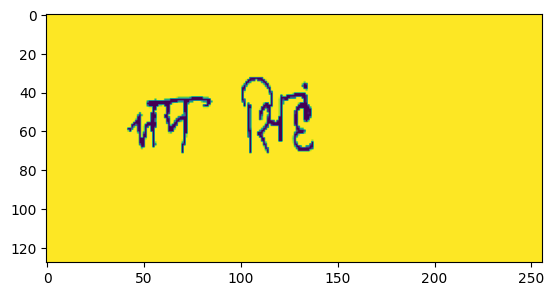

In [15]:
rr = np.random.randint(5000)
print(rr)
print(labels[rr])
plt.imshow(images[rr])
plt.show()
plt.imshow(processed_images[rr])
plt.show()
# plt.imshow(filtered_images[rr])
# plt.show()

In [16]:
# To Convert the labels to categorical format
categorical_labels = to_categorical(np.array(['forgery' == label for label in labels]), num_classes=2)

In [17]:
# Training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(processed_images, categorical_labels, test_size=0.2, random_state=42)

In [18]:
print(f"Training set: {X_train.shape}, {X_val.shape}")
print(f"Validation set: {y_train.shape}, {y_val.shape}")

Training set: (9024, 128, 256), (2256, 128, 256)
Validation set: (9024, 2), (2256, 2)


In [19]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [21]:
inputs = Input(shape=(128,256,1,))


t1 = layers.Conv2D(16, kernel_size=(1, 1), activation='relu',padding='same')(inputs)
t2 = layers.Conv2D(24, kernel_size=(3, 3), activation='relu',padding='same')(inputs)
t3 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu',padding='same')(inputs)
t4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding="same")(inputs)
x = layers.concatenate([t1, t2, t3, t4], axis=-1)


# We can also uncomment the below lines to improve the model architecture and training with better computation power

# t1 = layers.Conv2D(16, kernel_size=(1, 1), activation='relu',padding='same')(x)
# t2 = layers.Conv2D(24, kernel_size=(3, 3), activation='relu',padding='same')(x)
# t3 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu',padding='same')(x)
# t4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding="same")(x)
# x = layers.concatenate([t1, t2, t3, t4], axis=-1)


# t1 = layers.Conv2D(16, kernel_size=(1, 1), activation='relu',padding='same')(x)
# t2 = layers.Conv2D(24, kernel_size=(3, 3), activation='relu',padding='same')(x)
# t3 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu',padding='same')(x)
# t4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding="same")(x)
# x = layers.concatenate([t1, t2, t3, t4], axis=-1)
# x = layers.Dropout(0.2)(x)



x = layers.Conv2D(16, (3, 3), padding="same", activation="relu")(x)
x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)

x = layers.Flatten()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)


outputs = layers.Dense(2, activation='softmax')(x)  # 2 for genuine/forgery

model2 = Model(inputs=inputs, outputs=outputs)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()
model2.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))
# Result - accuracy: 0.8903 - loss: 0.2655 - val_accuracy: 0.7465 - val_loss: 0.6141

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │         32 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 256,  │        240 │ input_layer[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 256,  │        832 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 256,  │          0 │ input_layer[0][0] │
│ (MaxPooling2D)      │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 256,  │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 73)               │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │     10,528 │ concatenate[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 64, 128,   │          0 │ conv2d_3[0][0]    │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 131072)    │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 16,777,344 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        258 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,805,746 (64.11 MB)

 Trainable params: 16,805,746 (64.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 1124s 4s/step - accuracy: 0.5523 - loss: 0.9875 - val_accuracy: 0.6618 - val_loss: 0.6150
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 1128s 4s/step - accuracy: 0.7017 - loss: 0.6034 - val_accuracy: 0.7207 - val_loss: 0.5511
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 1100s 4s/step - accuracy: 0.7759 - loss: 0.4860 - val_accuracy: 0.7332 - val_loss: 0.5390
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 1119s 4s/step - accuracy: 0.8384 - loss: 0.3754 - val_accuracy: 0.7544 - val_loss: 0.5850
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 1104s 4s/step - accuracy: 0.8903 - loss: 0.2655 - val_accuracy: 0.7465 - val_loss: 0.6141


In [23]:
model2.save("signature_verification_model.h5")


In [27]:
# Model Evaluation
loss, accuracy = model2.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")
# Validation Loss: 0.6141, Validation Accuracy: 0.7465

71/71 ━━━━━━━━━━━━━━━━━━━━ 64s 896ms/step - accuracy: 0.7312 - loss: 0.6548
Validation Loss: 0.6141, Validation Accuracy: 0.7465


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return precision, recall, f1

In [29]:
y_pred = (model2.predict(X_val) > 0.5).astype(int)
y_true = np.argmax(y_val, axis=1)

71/71 ━━━━━━━━━━━━━━━━━━━━ 64s 895ms/step


In [34]:
y_pred_binary = np.argmax(model2.predict(X_val), axis=1)

precision, recall, f1 = calculate_metrics(y_true, y_pred_binary)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 63s 889ms/step
Precision: 0.8240, Recall: 0.6754, F1-Score: 0.7423


(2256,)


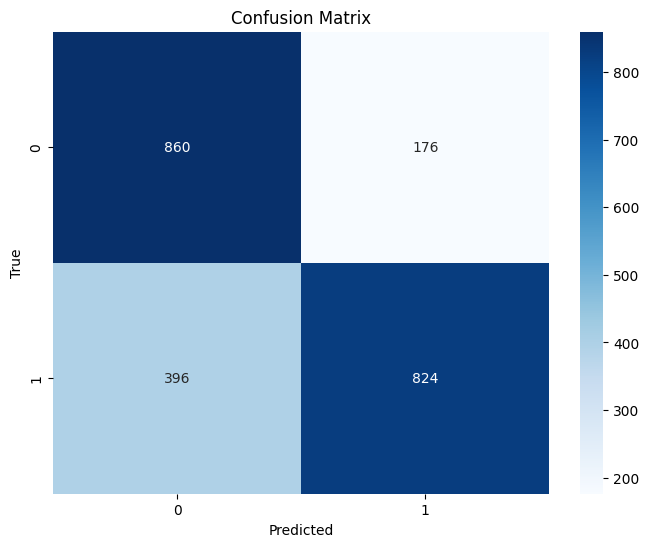

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


print(np.shape(y_true))
# print(np.shape(y_pred_binary))
cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# The confusion matrix shows that the model correctly classified 860 genuine signatures and 824 forged signatures,
# while misclassifying 396 genuine signatures as forged and 176 forged signatures as genuine.